In [27]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt1
import timeit
import sys
import os
from sklearn.cross_validation import KFold
from collections import OrderedDict
import operator
import random
from sklearn.cluster import KMeans
import numpy as np
import scipy.linalg as LA
import scipy.sparse
import sklearn.utils.arpack as SLA
from sklearn.base import ClassifierMixin
from sklearn.base import BaseEstimator
from sklearn.manifold import spectral_embedding
from pyspark.mllib.clustering import GaussianMixture, GaussianMixtureModel
import sklearn.metrics.pairwise as pairwise
from sklearn import decomposition as pca
from scipy import interpolate as ip
import sklearn.mixture as mixture
import sys
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.neighbors import DistanceMetric
from pyspark.sql import SQLContext
from pyspark.sql.types import *
%matplotlib inline

dataX,dataY=datasets.make_blobs(n_samples=10000, n_features=50, centers=2, cluster_std=3.5, center_box=(-10.0, 10.0), shuffle=True, random_state=None)

def labelremover(X,y):
    newX1 = np.around(X,decimals=2)
    newY1=np.copy(y)
    dim = X.shape[1]
    points = np.array(np.empty(len(np.unique(y))))
    knownX = np.empty((len(points),dim))
    knownY = np.empty(len(points))
    for i in np.unique(y):
        points[i] = np.where(y==(i))[0][0]
    for j in np.arange(0,len(newY1)):
        newY1[j]=-1
    for k in np.unique(y):
        newY1[points[k]] = y[points[k]]
    knownX = X[[i for i in points]]
    knownY = y[[i for i in points]]
    print "These are labels of known points: "+ str(knownY)
    return (newY1, knownX, knownY)

trainX = dataX[0:8000,:]
trainY = dataY[0:8000]
testX = dataX[8000:10000,:]
testY = dataY[8000:10000]


newtrainY, knownX, knownY = labelremover(trainX,trainY)


These are labels of known points: [0 1]


/home/madhura/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:46: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [28]:
#standalone code
with open('/home/madhura/Computational_Olfaction/fergus-ssl/src/fergus_propagation.py') as source_file:
    exec(source_file.read())

fp = FergusPropagation()
fp.fit(trainX,newtrainY)
predicted_labels = fp.predict(testX)

In [29]:
#distributed code
%run LabelPropagationDistributed.ipynb
lpd = LabelPropagationDistributed()
dX = sc.parallelize(trainX)
dy = sc.parallelize(newtrainY)
lpd.fit(dX,dy)

plabels_ = lpd.predict(sc.parallelize(testX))

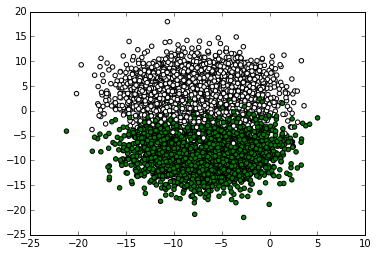

In [30]:
plt.scatter(trainX[:, 0], trainX[:, 1], marker='o', c=trainY, cmap = ('ocean'))

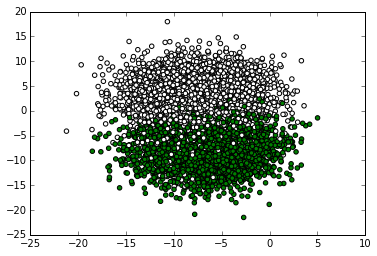

In [31]:
plt.scatter(trainX[:,0], trainX[:,1], c=np.array(lpd.labels_.collect()), cmap = (('ocean')))

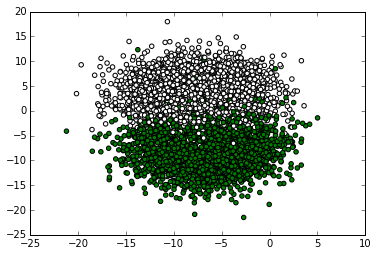

In [32]:
plt.scatter(trainX[:, 0], trainX[:, 1], marker='o', c=fp.labels_, cmap = ('ocean'))

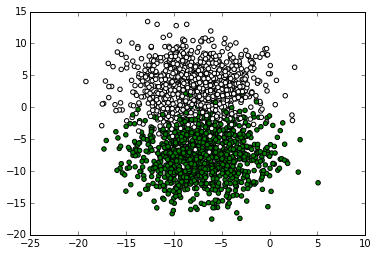

In [33]:
plt.scatter(testX[:, 0], testX[:, 1], marker='o', c=testY, cmap = ('ocean'))

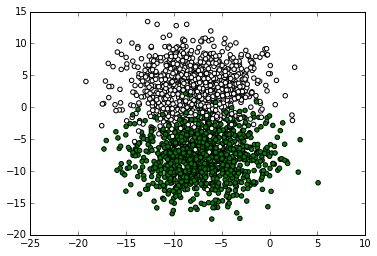

In [34]:
plt.scatter(testX[:,0], testX[:,1], c=np.array(plabels_.collect()), cmap = (('ocean')))

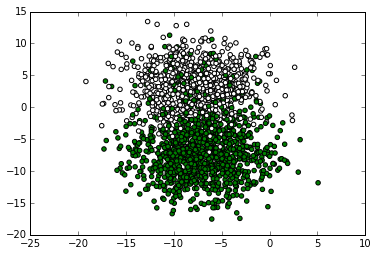

In [35]:
plt.scatter(testX[:, 0], testX[:, 1], marker='o', c=predicted_labels, cmap = ('ocean'))

In [36]:
np.where(trainY!=fp.labels_)[0].shape[0]

69

In [37]:
np.where(trainY!=np.array(lpd.labels_.collect()))[0].shape[0]

370

In [38]:
np.where(testY!=np.array(plabels_.collect()))[0].shape[0]

12

In [39]:
np.where(testY!=predicted_labels)[0].shape[0]

133

In [48]:
def getcount(gt,new):
    diff = np.where(gt!=new)[0].shape[0]
    return (float(diff)/float(len(gt)))
    

print "Training Error in standalone:",
print getcount(trainY, fp.labels_)
print "Training Error in distributed:",
print getcount(trainY, lpd.labels_.collect())
print "Test Error in standalone:",
print getcount(testY, predicted_labels)
print "Test Error in distributed:",
print getcount(testY, plabels_.collect())

Training Error in standalone: 0.008625
Training Error in distributed: 0.04625
Test Error in standalone: 0.0665
Test Error in distributed: 0.006
